<style>
    .center-text{
        text-align: center;
    }
</style>

<div class='center-text'>

# Tarea 1 Aprendizaje Automático

### Julian Ricardo Salazar duarte

#### Universidad Nacional de Colombia

#### 2024-1
</div>


- [1. Preprocesamiento de datos](#s1)
- [2. Análisis exploratorio de datos](#s2)
- [3. Modelos de regresión](#s3)


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import mlflow
import optuna
import xgboost as xgb

<a id="s1"></a>
### 1. Preprocesamiento de datos

In [70]:
def load_data(filename, skiprows=0, sheet_name=None):
    if sheet_name is None:
        data = pd.read_excel(filename, skiprows=skiprows)
    else:
        data = pd.read_excel(filename, skiprows=skiprows, sheet_name=sheet_name)
    return data

In [71]:
def clean_df(df):

    df = df.dropna(how='all')

    for i in range (len(df.columns)):
        if 'Unnamed' in df.columns[i]:
            df = df.rename(columns={df.columns[i]: df.columns[i-1].split()[0] + ' ' + df.iloc[0, i]})
        elif not pd.isna(df.iloc[0, i]):
            df = df.rename(columns={df.columns[i]: df.columns[i] + ' ' + df.iloc[0, i]})

    df = df.drop(df.index[0])
    df = df.dropna(how='any')
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.capitalize()
    df['Fecha'] = df['Fecha'].apply(str)

    df = df.rename(columns={df.columns[2]: 'Marca'})
    
    return df

In [72]:
df = load_data('CC FT 17 Formato de Control de Calidad Café de Trillado.xlsx',
               5, ['CONTROL CALIDAD CAFE TRILLADO J', 'Sheet2'])

df1 = df['CONTROL CALIDAD CAFE TRILLADO J']
df2 = df['Sheet2']

df1 = clean_df(df1)
df2 = clean_df(df2)

In [73]:
df_trillado = pd.concat([df1, df2], axis=0)

for col in df_trillado.columns:
    if isinstance(df_trillado[col].iloc[0], str):
        df_trillado[col] = df_trillado[col].str.lower().str.strip()
    if len(set(df_trillado[col])) == 1:
        df_trillado = df_trillado.drop(columns=[col])

df_trillado['Lote'] = df_trillado['Lote'].str.replace('-', '', regex=False).str.lstrip('0')

df_trillado = df_trillado.reset_index(drop=True)

print(df_trillado.shape)

(106, 9)


##### Label (X) e input (Y)


In [74]:
def replace_date(date):
    date = date.split('-')
    if date[1].isdigit():
        if int (date[1]) < 4:
            return 1
        elif int (date[1]) < 7:
            return 2
        elif int (date[1]) < 10:
            return 3
        else:
            return 4
    else:
        if 'ene' in date[1].lower() or 'feb' in date[1].lower() or 'mar' in date[1].lower():
            return 1
        elif 'abr' in date[1].lower() or 'may' in date[1].lower() or 'jun' in date[1].lower():
            return 2
        elif 'jul' in date[1].lower() or 'ago' in date[1].lower() or 'sep' in date[1].lower():
            return 3
        else:
            return 4

In [75]:
# Fecha toma los valores entre 1 y 4 dividiendo el año en trimestres

df_trillado['Fecha'] = df_trillado['Fecha'].apply(replace_date)

In [76]:
def replace_lote(lote):
    if len(lote) == 7:
        return int(lote[0])
    else:
        return int(lote[:2])

In [77]:
# La columna Lote tiene valores enteros en entre 1 y 23 representando la marca o tipo de cafe

df_trillado['Lote'] = df_trillado['Lote'].apply(replace_lote)

In [78]:
tmp = df_trillado[['Lote', 'Marca']]
tmp = tmp.drop_duplicates(subset='Lote')
print(tmp)

    Lote                       Marca
0      1                 madre laura
1      9                tabi natural
2     10                   don mario
3      7                   don felix
7      8         gesha villabernarda
8      2         madre laura natural
9      5                  doña dolly
12     3    madre laura descafeinado
17    11      monteverde - wush wush
18    12     el ocaso - pink bourbon
28    13   el cedrela - pink bourbon
38    16       gesha villa - natural
39    15         don victor - marago
42     6                  don rafael
43     4                doña rosalba
49    17      familia bedoya castaño
54    18                   don johan
57    19     gesha blue - monteverde
58    20  bourbon sidra - las flores
59    21    don victor - red bourbon
70    22         el ocaso - caturron
72    23             esteban robledo


In [79]:
df = load_data('CC FT 17 Formato de Control de Calidad Café de Trillado.xlsx', sheet_name=['LOTES'])
df = df['LOTES']
df = df[['N°', 'TIPO DE CAFÉ']]
df['TIPO DE CAFÉ'] = df['TIPO DE CAFÉ'].str.lower()
df = df.dropna(how='any')
df = df.set_index('N°')
dict_lote = df.to_dict()['TIPO DE CAFÉ']
dict_lote[23] = tmp[tmp['Lote'] == 23]['Marca'].values[0]

In [80]:
for key, value in dict_lote.items():
    print(f'{key}: {value}')

1: madre laura lavado
2: madre laura natural
3: madre laura descafeinado
4: doña rosalba 
5: doña dolly
6: don rafael pbw 
7: don felix
8: gesha villabernarda
9: don juan tabi
10: doña liceth 
11: monteverde - wush wush
12: el ocaso - pink bourbon
13: el cedrela - pink bourbon 
14: don reinaldo 
15: don victor - maragogipe 
16: gesha natural villabernarda
17: familia bedoya castaño
18: don johan 
19: familia gutierrez - gesha 
20: familia vergara - bourbon sidra 
21: don victor - red bourbon
22: el ocaso - caturron natural 
23: esteban robledo


In [81]:
# se elimina la columna marca ya que es redundante con la columna Lote

df_trillado = df_trillado.drop(columns=['Marca'])

In [82]:
# normalizar la columna Cantidad
scaler = MinMaxScaler()
df_trillado['Cantidad'] = scaler.fit_transform(df_trillado[['Cantidad']])

In [83]:
# %h se deja igual
# mallas # se elimina ya que no se tiene informacion sobre que significa
df_trillado = df_trillado.drop(columns=['Mallas #'])

In [84]:
df_trillado = df_trillado.drop(columns=('Cantidad'))

In [85]:

tmp = df_trillado['Notas de catación']
tmp = tmp.str.split(',', expand=True)

In [86]:
def separe_y(row):
    new_row = []
    for r in row:
        tmp = r.split(' y ')
        new_row.extend(tmp)
    return new_row


In [87]:
def delete_and_normalize(row):
    
    new_row = []
    for r in row:
        if (r == 'caramleo' or r == 'balanaceado' or 'fnal' in r or 'final' in r or 
            'residual' in r or 'cuepo' in r or 'prolongado' in r):
            continue
        elif 'acidez' in r or 'cuerpo' in r:
            pos = r.find(' ', 7)
            if pos == -1:
                new_row.append(r.replace('.', ''))
            else:
                new_row.append(r[:pos])
        elif 'mora' in r:
            new_row.append('mora')
        elif 'miel' in r:
            new_row.append('miel')
        elif 'fresa' in r:
            new_row.append('fresa')
        elif 'chocolate' in r:
            new_row.append('chocolate')
        elif 'cacao' in r:
            new_row.append('cacao')
        elif 'panela' in r:
            new_row.append('panela')
        else:
            new_row.append(r.replace('.', ''))
    return new_row

In [88]:
# Notas de catacion se aplicará One-Hot Encoding

notes = set()
for i in range(tmp.shape[1]):
    notes = notes.union(set(tmp[i].str.strip()))

notes = list(notes)
notes = [note for note in notes if note is not None]
notes = separe_y(notes)
notes = delete_and_normalize(notes)
notes = list(set(notes))
notes.sort()

In [89]:
for col in notes:
    df_trillado[col] = np.nan

In [90]:
for i in notes:
    for j in df_trillado.index:
        if i in df_trillado.at[j, 'Notas de catación']:
            df_trillado.at[j, i] = 1
        else:
            df_trillado.at[j, i] = 0

In [91]:
# Se eliminan las columnas Notas de catación ya que se aplicó One-Hot Encoding

df_trillado = df_trillado.drop(columns=['Notas de catación'])

In [92]:
# eliminar las columnas que tengan olo un 1 en one hot encoding

for col in df_trillado.columns:
    cnt = df_trillado.apply(lambda col: (col == 1).sum())
    if cnt[col] == 1:
        df_trillado = df_trillado.drop(columns=[col])

In [93]:
# responsable sa cambia lfq por 1 y ac por 0
for i in df_trillado.index:
    if df_trillado.at[i, 'Responsable'] == 'lfq':
        df_trillado.at[i, 'Responsable'] = 1
    else:
        df_trillado.at[i, 'Responsable'] = 0

In [94]:
df_trillado.head()

,Fecha,Lote,%h %,Puntaje n°,Responsable,acidez brillante,acidez citrica,acidez jugosa,acidez malica,acidez media,...,mandarina,maracuya,miel,mora,naranja,panela,rosas,sandia,te de cedron,toque frutal
0,3,1,10.9,84,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,9,10.2,85,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,10,10.7,84.5,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,7,10.5,84.5,1,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,1,10.7,84,1,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [95]:
for i in df_trillado.index:
    if isinstance(df_trillado.at[i, 'Puntaje n°'], str):
        df_trillado.at[i, 'Puntaje n°'] = float(df_trillado.at[i, 'Puntaje n°'].replace(',', '.'))
    if isinstance(df_trillado.at[i, '%h %'], str):
        df_trillado.at[i, '%h %'] = float(df_trillado.at[i, '%h %'].replace(',', '.'))

In [96]:
# Seleccionar columnas que son de tipo int o float
numeric_cols = df_trillado.select_dtypes(include=['int64', 'float64']).columns

# Verificar si todas las columnas son numéricas
if len(numeric_cols) == df_trillado.shape[1]:
    print("Todas las columnas son de tipo int o float.")
else:
    print("No todas las columnas son de tipo int o float.")
    non_numeric_cols = df_trillado.columns.difference(numeric_cols)
    print("Columnas no numéricas:", non_numeric_cols)

    # Intentar convertir las columnas no numéricas a float
    for col in non_numeric_cols:
        try:
            df_trillado[col] = df_trillado[col].astype(float)
            print(f"Columna {col} convertida a float.")
        except ValueError:
            print(f"No se pudo convertir la columna {col} a float.")

# Verificar nuevamente si todas las columnas son numéricas
numeric_cols = df_trillado.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) == df_trillado.shape[1]:
    print("Ahora todas las columnas son de tipo int o float.")
else:
    print("Aún hay columnas que no son de tipo int o float.")
    non_numeric_cols = df_trillado.columns.difference(numeric_cols)
    print("Columnas no numéricas restantes:", non_numeric_cols)

No todas las columnas son de tipo int o float.
Columnas no numéricas: Index(['%h %', 'Puntaje n°', 'Responsable'], dtype='object')
Columna %h % convertida a float.
Columna Puntaje n° convertida a float.
Columna Responsable convertida a float.
Ahora todas las columnas son de tipo int o float.


In [97]:
# dividir datos en features y target

X = df_trillado.drop(columns=['Puntaje n°'])

y = df_trillado['Puntaje n°']

Se buscara predecir el puntaje de los granos  de café (y) en base de las caracteristicas Fecha, Lote, cantidad, %h, Mallas y notas de catación (x). Para ello se realizó un preprocesamiento de los datos, con el fin de tener un dataset limpio y listo para ser utilizado en modelos de ml.

<a id="s2"></a>
### 2. Análisis exploratorio de datos

In [98]:
print("Primeras filas de caracteristicas:\n")
print(X.head())


Primeras filas de caracteristicas:

   Fecha  Lote  %h %  Responsable  acidez brillante  acidez citrica  \
0      3     1  10.9          1.0               0.0             0.0   
1      3     9  10.2          1.0               1.0             0.0   
2      3    10  10.7          1.0               1.0             0.0   
3      3     7  10.5          1.0               0.0             0.0   
4      4     1  10.7          1.0               0.0             0.0   

   acidez jugosa  acidez malica  acidez media  arandanos  ...  mandarina  \
0            1.0            0.0           0.0        0.0  ...        0.0   
1            0.0            0.0           0.0        0.0  ...        0.0   
2            0.0            0.0           0.0        0.0  ...        0.0   
3            0.0            0.0           1.0        0.0  ...        0.0   
4            1.0            0.0           0.0        0.0  ...        0.0   

   maracuya  miel  mora  naranja  panela  rosas  sandia  te de cedron  \
0      

In [99]:
print("\nÚltimas filas de caracteristicas:\n")
print(X.tail())


Últimas filas de caracteristicas:

     Fecha  Lote  %h %  Responsable  acidez brillante  acidez citrica  \
101      4     1  10.5          0.0               0.0             0.0   
102      1     1  10.4          0.0               0.0             0.0   
103      2     1  10.5          0.0               0.0             0.0   
104      2     1  10.8          0.0               0.0             0.0   
105      3     1  10.2          0.0               0.0             0.0   

     acidez jugosa  acidez malica  acidez media  arandanos  ...  mandarina  \
101            1.0            0.0           0.0        0.0  ...        0.0   
102            1.0            0.0           0.0        0.0  ...        0.0   
103            1.0            0.0           0.0        0.0  ...        0.0   
104            1.0            0.0           0.0        0.0  ...        0.0   
105            1.0            0.0           0.0        0.0  ...        0.0   

     maracuya  miel  mora  naranja  panela  rosas  sandi

In [100]:
print("Primeras filas de objetivos:\n")
print(y.head())
print("\nÚltimas filas de objetivos:\n")
print(y.tail())

Primeras filas de objetivos:

0    84.0
1    85.0
2    84.5
3    84.5
4    84.0
Name: Puntaje n°, dtype: float64

Últimas filas de objetivos:

101    84.0
102    84.0
103    84.0
104    84.0
105    84.0
Name: Puntaje n°, dtype: float64


In [101]:
print("Resumen estadístico de caracteristicas:")
print(X.describe())

Resumen estadístico de caracteristicas:
            Fecha        Lote        %h %  Responsable  acidez brillante  \
count  106.000000  106.000000  106.000000   106.000000        106.000000   
mean     2.632075    5.509434   10.557547     0.716981          0.292453   
std      1.132427    5.868796    0.234195     0.452606          0.457050   
min      1.000000    1.000000   10.000000     0.000000          0.000000   
25%      2.000000    1.000000   10.400000     0.000000          0.000000   
50%      3.000000    2.000000   10.500000     1.000000          0.000000   
75%      4.000000    8.000000   10.800000     1.000000          1.000000   
max      4.000000   23.000000   11.300000     1.000000          1.000000   

       acidez citrica  acidez jugosa  acidez malica  acidez media   arandanos  \
count      106.000000     106.000000     106.000000    106.000000  106.000000   
mean         0.018868       0.632075       0.018868      0.037736    0.028302   
std          0.136705       0.48

In [102]:
print("Información de caracteristicas:")
print(X.info())

Información de caracteristicas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fecha                 106 non-null    int64  
 1   Lote                  106 non-null    int64  
 2   %h %                  106 non-null    float64
 3   Responsable           106 non-null    float64
 4   acidez brillante      106 non-null    float64
 5   acidez citrica        106 non-null    float64
 6   acidez jugosa         106 non-null    float64
 7   acidez malica         106 non-null    float64
 8   acidez media          106 non-null    float64
 9   arandanos             106 non-null    float64
 10  cacao                 106 non-null    float64
 11  caramelo              106 non-null    float64
 12  cedro                 106 non-null    float64
 13  chocolate             106 non-null    float64
 14  clavos de olor        106 non-null    floa

In [103]:
print("Información de objetivos:")
print(y.info())

Información de objetivos:
<class 'pandas.core.series.Series'>
RangeIndex: 106 entries, 0 to 105
Series name: Puntaje n°
Non-Null Count  Dtype  
--------------  -----  
106 non-null    float64
dtypes: float64(1)
memory usage: 980.0 bytes
None


In [104]:
print("Valores nulos en caracteristicas:")
print(X.isnull().sum())

Valores nulos en caracteristicas:
Fecha                   0
Lote                    0
%h %                    0
Responsable             0
acidez brillante        0
acidez citrica          0
acidez jugosa           0
acidez malica           0
acidez media            0
arandanos               0
cacao                   0
caramelo                0
cedro                   0
chocolate               0
clavos de olor          0
cuerpo aterciopelado    0
cuerpo cremoso          0
cuerpo medio            0
cuerpo sedoso           0
durazno                 0
frambuesa               0
fresa                   0
frutas maduras          0
frutos rojos            0
jazmin                  0
lavanda                 0
limon                   0
mandarina               0
maracuya                0
miel                    0
mora                    0
naranja                 0
panela                  0
rosas                   0
sandia                  0
te de cedron            0
toque frutal            0
dtyp

In [105]:
print("Valores nulos en Y:")
print(y.isnull().sum())

Valores nulos en Y:
0


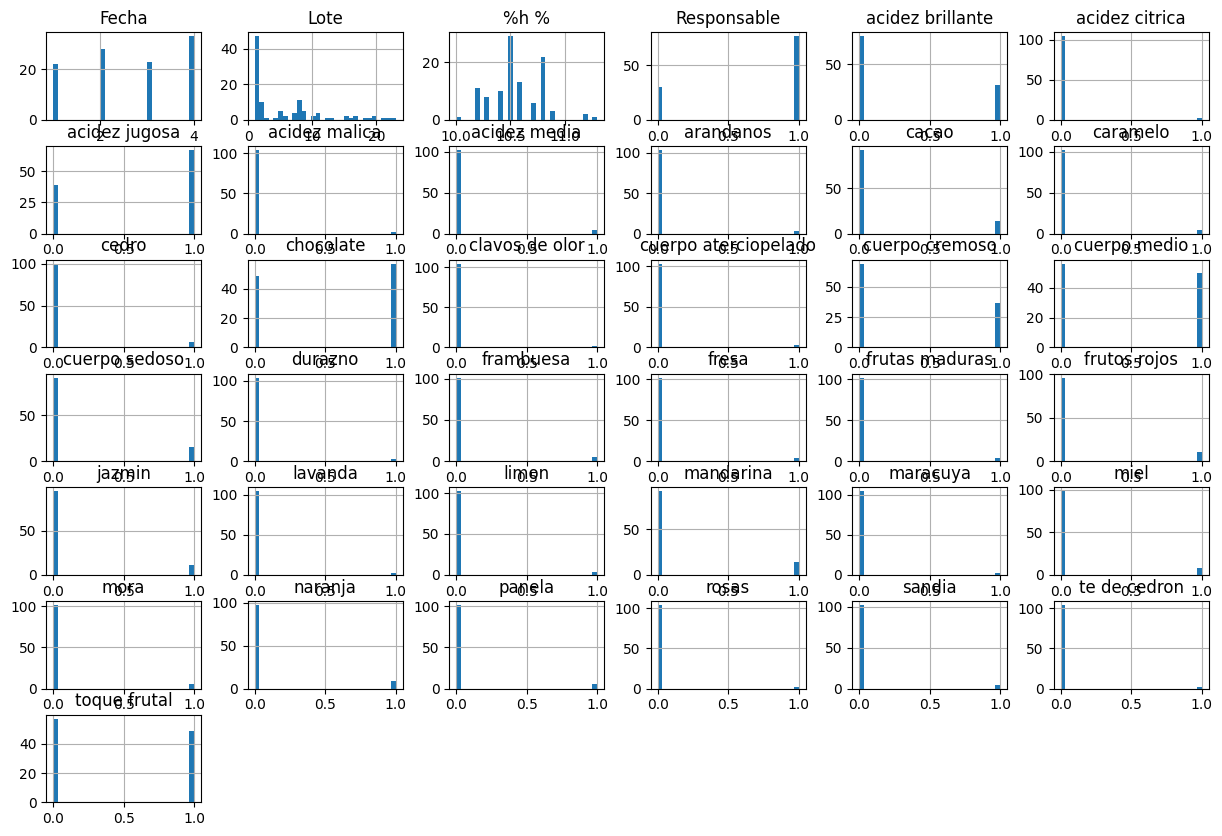

In [106]:
X.hist(bins=30, figsize=(15, 10))
plt.show()

In [107]:
# corr_matrix = X.corr()
# sns.heatmap(corr_matrix, annot=True)
# plt.show()

In [108]:
for col in X.columns:
    print(f"Frecuencia de categorías en {col}:")
    print(X[col].value_counts())

Frecuencia de categorías en Fecha:
Fecha
4    33
2    28
3    23
1    22
Name: count, dtype: int64
Frecuencia de categorías en Lote:
Lote
1     47
8     11
2     10
5      5
9      5
7      4
11     4
10     2
20     2
15     2
6      2
17     2
18     1
22     1
21     1
19     1
16     1
4      1
13     1
12     1
3      1
23     1
Name: count, dtype: int64
Frecuencia de categorías en %h %:
%h %
10.5    29
10.8    22
10.6    13
10.2    11
10.4    10
10.3     8
10.7     6
10.9     3
11.2     2
10.0     1
11.3     1
Name: count, dtype: int64
Frecuencia de categorías en Responsable:
Responsable
1.0    76
0.0    30
Name: count, dtype: int64
Frecuencia de categorías en acidez brillante:
acidez brillante
0.0    75
1.0    31
Name: count, dtype: int64
Frecuencia de categorías en acidez citrica:
acidez citrica
0.0    104
1.0      2
Name: count, dtype: int64
Frecuencia de categorías en acidez jugosa:
acidez jugosa
1.0    67
0.0    39
Name: count, dtype: int64
Frecuencia de categorías en acidez

In [109]:
# for col in X.select_dtypes(include=['float64', 'int64']).columns:
#     sns.boxplot(x=X[col])
#     plt.title(f"Boxplot de {col}")
#     plt.show()

In [110]:
# sns.pairplot(X)
# plt.show()

In [111]:
for col in X.columns:
    print(f"Estadísticas agregadas por {col}:")
    print(X.groupby(col).mean())

Estadísticas agregadas por Fecha:
           Lote       %h %  Responsable  acidez brillante  acidez citrica  \
Fecha                                                                       
1      5.227273  10.577273     0.681818          0.136364        0.000000   
2      6.285714  10.471429     0.785714          0.357143        0.000000   
3      6.956522  10.617391     0.913043          0.478261        0.043478   
4      4.030303  10.575758     0.545455          0.212121        0.030303   

       acidez jugosa  acidez malica  acidez media  arandanos     cacao  ...  \
Fecha                                                                   ...   
1           0.818182       0.000000      0.045455   0.045455  0.090909  ...   
2           0.607143       0.000000      0.035714   0.035714  0.214286  ...   
3           0.347826       0.043478      0.086957   0.043478  0.173913  ...   
4           0.727273       0.030303      0.000000   0.000000  0.060606  ...   

       mandarina  maracuya  

In [112]:
# converir df a numpy array

X = X.values
y = y.values

In [113]:
# dividir datos en entrenamiento, prueba y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

print("Tamaño de datos de entrenamiento:")
print(X_train.shape, y_train.shape)
print("Tamaño de datos de prueba:")
print(X_test.shape, y_test.shape)
# print("Tamaño de datos de validación:")
# print(X_val.shape, Y_val.shape)

Tamaño de datos de entrenamiento:
(74, 37) (74,)
Tamaño de datos de prueba:
(32, 37) (32,)


<a id="s3"></a>
### 3. Modelos de regresión

In [114]:
def cross_val(X, y, model, k=5):


    # Calcular R^2 utilizando K-Fold Cross-Validation
    r2_scores = cross_val_score(model, X, y, cv=k, scoring='r2')
    
    print(f"R^2 Scores: {r2_scores}")
    print(f"R^2 Promedio: {r2_scores.mean()}")

    # Calcular Mean Absolute Error (MAE)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    mae_scores = cross_val_score(model, X, y, cv=k, scoring=mae_scorer)
    
    print(f"MAE Scores: {-mae_scores}")
    print(f"MAE Promedio: {-mae_scores.mean()}")

    # Calcular Mean Squared Error (MSE)
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mse_scores = cross_val_score(model, X, y, cv=k, scoring=mse_scorer)

    print(f"MSE Scores: {-mse_scores}")
    print(f"MSE Promedio: {-mse_scores.mean()}")

In [151]:
def model_prediction(model, X, y):
    metrics = {}

    y_pred = model.predict(X)

    metrics['mse'] = mean_squared_error(y, y_pred)
    metrics['r2'] = r2_score(y, y_pred)
    metrics['mae'] = mean_absolute_error(y, y_pred)
    metrics['mape'] = np.mean(np.abs((y - y_pred) / y)) * 100

    return y_pred, metrics

In [152]:
def plot_model(y_test, y_pred, metrics):
        print(f"Mean Squared Error: {metrics['mse']}")
        print(f"R^2 Score: {metrics['r2']}")
        print(f"Mean Absolute Error: {metrics['mae']}")
        print(f"Mean Absolute Percentage Error: {metrics['mape']}")

        bias = np.mean(y_test - y_pred)

    # Calcular la varianza
        variance = np.var(y_pred)

        print(f'\nBias: {bias}')
        print(f'Varianza: {variance}')

        # Graficar los resultados
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label='Real')
        plt.plot(y_pred, label='Predicción')
        plt.legend()
        plt.title("Predicción vs Real")
        plt.savefig("prediction_plot.png")
        plt.grid()
        plt.show()

In [117]:
def save_model(model, model_name, metrics, params=None, sk=True):
    with mlflow.start_run():
        # mlflow.set_experiment('cafe')
        if params is not None:
            for key, value in params.items():
                mlflow.log_param(key, value)
        mlflow.log_metric('mse', metrics['mse'])
        mlflow.log_metric('r2', metrics['r2'])
        mlflow.log_metric('mae', metrics['mae'])
        mlflow.log_metric('mape', metrics['mape'])
        mlflow.log_artifact('prediction_plot.png')
        if sk:
            mlflow.sklearn.log_model(model, model_name)
        else:
            mlflow.xgboost.log_model(model, model_name)


In [118]:
def best_5_models(grid):
    results = pd.DataFrame(grid.cv_results_)

    results = results.sort_values(by='mean_test_score', ascending=False)

    top_5_models = results.head(5)

    print('mejores 5 modelos:')
    print(top_5_models[['params', 'mean_test_score']])

In [119]:
def best_params(grid):
    params = grid.best_params_

    print("Mejores parámetros:")
    for key, value in params.items():
        print(f"    {key}: {value}")
    return params

#### 3.1 Regresión lineal

In [153]:
model = LinearRegression()

cross_val(X_train, y_train, model)

model.fit(X_train, y_train)

#y_pred, tmp = model_prediction(model, X_test, y_test)

# plot_model(y_test, y_pred, tmp)

# save_model(model, 'linear_regression', tmp)


R^2 Scores: [0.89199023 0.91771176 0.85229697 0.85393983 0.8923444 ]
R^2 Promedio: 0.8816566367878123
MAE Scores: [0.15688522 0.19571175 0.22850982 0.26136363 0.16470917]
MAE Promedio: 0.20143591772157965
MSE Scores: [0.13561227 0.23497865 0.42669765 0.33496465 0.21860678]
MSE Promedio: 0.2701720000290707


LinearRegression()

Rendimiento en entrenamiento
Mean Squared Error: 0.002222537178754712
R^2 Score: 0.9990569984626936
Mean Absolute Error: 0.012892601782352981
Mean Absolute Percentage Error: 0.015213227824555673

Bias: -3.8407715446491904e-16
Varianza: 2.354652919358865


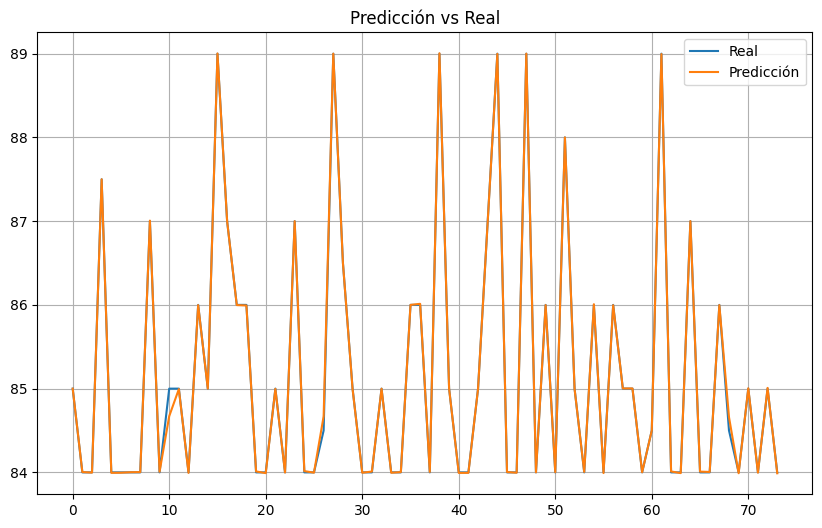

In [154]:
print("Rendimiento en entrenamiento")
y_train_pred, tmp = model_prediction(model, X_train, y_train)
plot_model(y_train, y_train_pred, tmp)

Rendimiento en prueba
Mean Squared Error: 0.14656715670056902
R^2 Score: 0.8804105430586592
Mean Absolute Error: 0.17687254347593973
Mean Absolute Percentage Error: 0.20769850045910448

Bias: -0.003035235455002283
Varianza: 1.1514793057956947


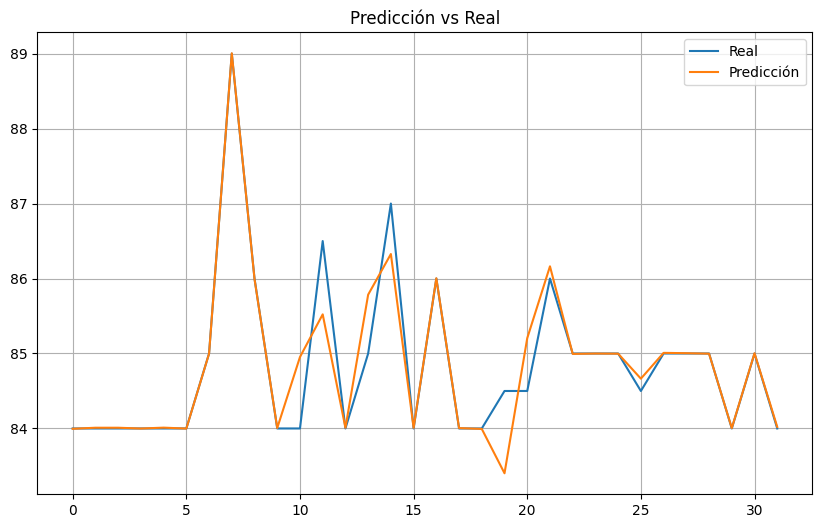

In [155]:
print("Rendimiento en prueba")
y_pred, tmp = model_prediction(model, X_test, y_test)
plot_model(y_test, y_pred, tmp)

#### 3.2 Suport Vector Machine

In [156]:
param_grid = {
    'gamma': ['scale', 'auto', 0.5],
    'kernel': ['linear', 'poly'],
    'epsilon': [0.1, 0.01, 0.001]
}

grid = GridSearchCV(SVR(), param_grid, refit=True,scoring='neg_mean_squared_error',
                    verbose=2, cv=3)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ............epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ............epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..............epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..............epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ..............epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .............epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .............epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END .............epsilon=0.1, gamma=auto, kernel=linear; total time=   0.0s
[CV] END ...............epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ...............epsilon=0.1, gamma=auto, kernel=poly; total time=   0.0s
[CV] END ...............epsilon=0.1, gamma=auto,

GridSearchCV(cv=3, estimator=SVR(),
             param_grid={'epsilon': [0.1, 0.01, 0.001],
                         'gamma': ['scale', 'auto', 0.5],
                         'kernel': ['linear', 'poly']},
             scoring='neg_mean_squared_error', verbose=2)

In [157]:
best_5_models(grid)

mejores 5 modelos:
                                               params  mean_test_score
9   {'epsilon': 0.01, 'gamma': 'auto', 'kernel': '...        -0.088836
15  {'epsilon': 0.001, 'gamma': 'auto', 'kernel': ...        -0.089922
3   {'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'p...        -0.105810
4   {'epsilon': 0.1, 'gamma': 0.5, 'kernel': 'line...        -0.224958
0   {'epsilon': 0.1, 'gamma': 'scale', 'kernel': '...        -0.224958


In [158]:
params = best_params(grid)

Mejores parámetros:
    epsilon: 0.01
    gamma: auto
    kernel: poly


In [162]:
model = SVR(**params)
model.fit(X_train, y_train)
cross_val(X_train, y_train, model)

R^2 Scores: [0.94254847 0.95356149 0.98989867 0.92753964 0.93102732]
R^2 Promedio: 0.9489151170360325
MAE Scores: [0.12075835 0.18660379 0.09037303 0.16290441 0.18508922]
MAE Promedio: 0.14914575716978812
MSE Scores: [0.07213359 0.13260775 0.02918162 0.16617577 0.14005677]
MSE Promedio: 0.10803109808212348


Rendimiento en entrenamiento
Mean Squared Error: 0.0032579396153032147
R^2 Score: 0.9986176869862741
Mean Absolute Error: 0.014549525824925908
Mean Absolute Percentage Error: 0.01706483225289923

Bias: 0.006381840726135316
Varianza: 2.3604114023181757


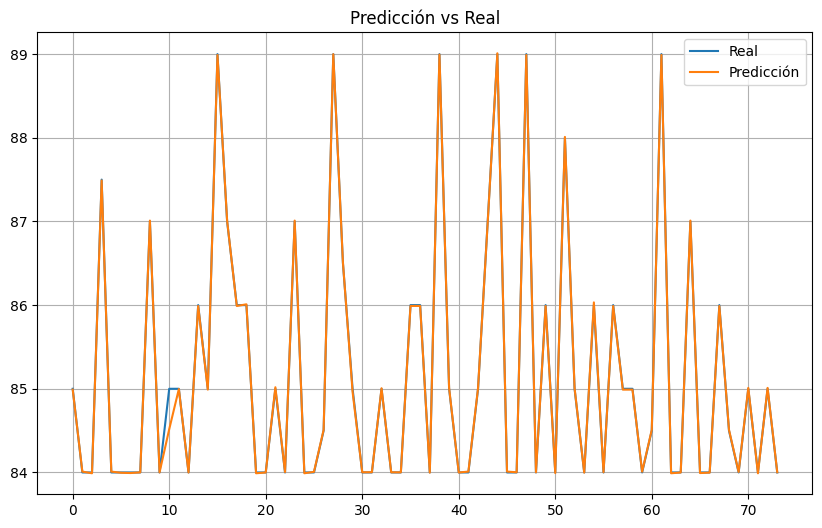

In [163]:
print("Rendimiento en entrenamiento")
y_train_pred, tmp = model_prediction(model, X_train, y_train)
plot_model(y_train, y_train_pred, tmp)

Rendimiento en prueba
Mean Squared Error: 0.12197723046525967
R^2 Score: 0.9004743553813339
Mean Absolute Error: 0.14259097660032838
Mean Absolute Percentage Error: 0.16679744698025892

Bias: 0.0281989347671181
Varianza: 1.0337516370100734


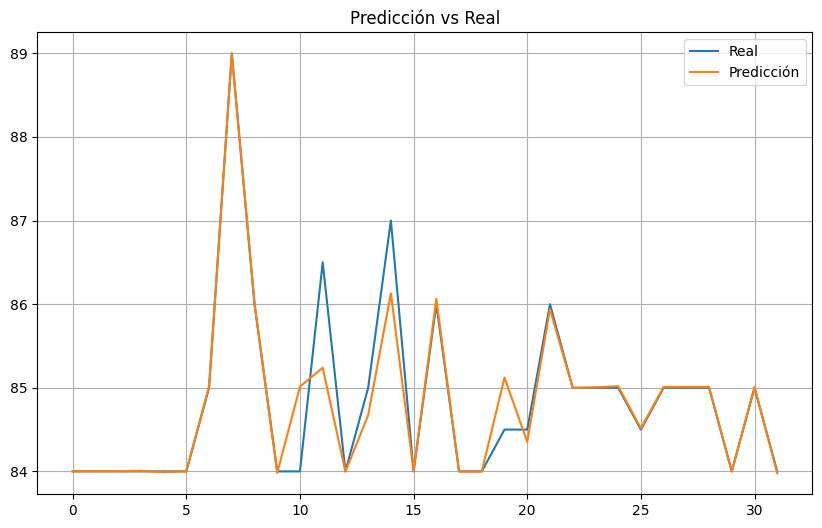

In [164]:
print("Rendimiento en prueba")
y_pred, tmp = model_prediction(model, X_test, y_test)
plot_model(y_test, y_pred, tmp)

#### 3.3 Random Forest

In [165]:
param_grid = {
    'n_estimators': [30, 40, 50],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 3]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, refit=True,
                    scoring='neg_mean_squared_error', verbose=2, cv=3)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=30; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_s

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 3],
                         'n_estimators': [30, 40, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [166]:
best_5_models(grid)

mejores 5 modelos:
                                               params  mean_test_score
15  {'max_depth': 20, 'max_features': 'sqrt', 'min...        -0.243221
27  {'max_depth': 30, 'max_features': 'sqrt', 'min...        -0.243221
3   {'max_depth': 10, 'max_features': 'sqrt', 'min...        -0.243222
32  {'max_depth': 30, 'max_features': 'log2', 'min...        -0.255448
20  {'max_depth': 20, 'max_features': 'log2', 'min...        -0.255448


In [167]:
params = best_params(grid)

Mejores parámetros:
    max_depth: 20
    max_features: sqrt
    min_samples_split: 3
    n_estimators: 30


In [168]:
model = RandomForestRegressor(**params, random_state=42)
cross_val(X_train, y_train, model)
model.fit(X_train, y_train)

R^2 Scores: [0.96074115 0.92794116 0.9153636  0.74801557 0.90156148]
R^2 Promedio: 0.8907245943892853
MAE Scores: [0.13418519 0.25953704 0.25183333 0.38385979 0.22450397]
MAE Promedio: 0.2507838624338622
MSE Scores: [0.04929167 0.20576801 0.24450515 0.57788429 0.19989046]
MSE Promedio: 0.2554679141156471


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=3,
                      n_estimators=30, random_state=42)

Mean Squared Error: 0.04186960397897936
R^2 Score: 0.982235122410546
Mean Absolute Error: 0.08953828828828923
Mean Absolute Percentage Error: 0.10320775814462169

Bias: 0.008802552552552164
Varianza: 2.1257208281620557


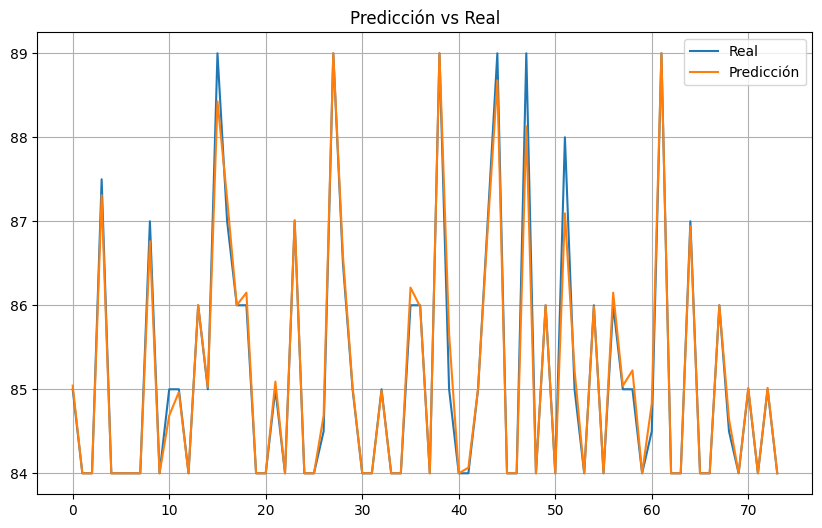

In [169]:
y_train_pred, tmp = model_prediction(model, X_train, y_train)
plot_model(y_train, y_train_pred, tmp)

Rendimiento en prueba
Mean Squared Error: 0.07622370756172914
R^2 Score: 0.937806313511386
Mean Absolute Error: 0.1269444444444452
Mean Absolute Percentage Error: 0.14874383357244966

Bias: -0.03434027777777926
Varianza: 1.1295735327449856


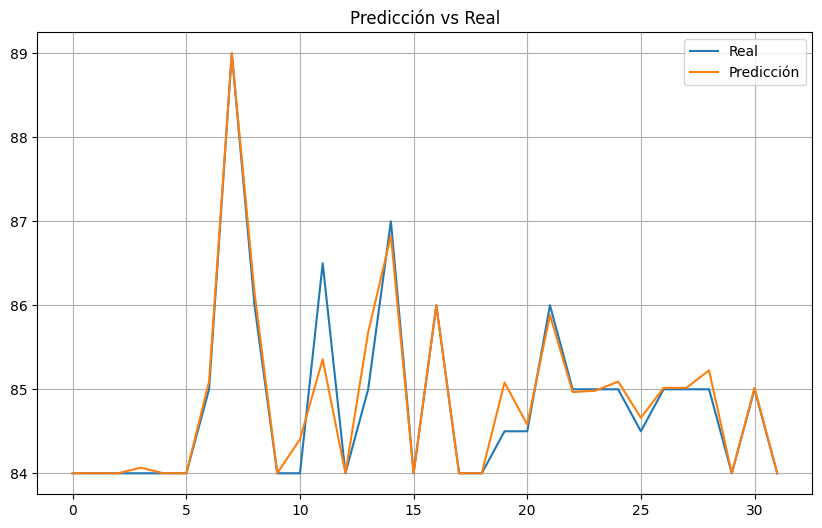

In [170]:
print("Rendimiento en prueba")
y_pred, tmp = model_prediction(model, X_test, y_test)
plot_model(y_test, y_pred, tmp)

#### 3.4 XGBoost

In [171]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(xgb.XGBRegressor(), param_grid, refit=True, cv=3,
                        scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [172]:
best_5_models(grid)

mejores 5 modelos:
                                               params  mean_test_score
23  {'colsample_bytree': 0.8, 'learning_rate': 0.1...        -0.139786
21  {'colsample_bytree': 0.8, 'learning_rate': 0.1...        -0.140123
19  {'colsample_bytree': 0.8, 'learning_rate': 0.1...        -0.142686
39  {'colsample_bytree': 0.8, 'learning_rate': 0.2...        -0.145729
41  {'colsample_bytree': 0.8, 'learning_rate': 0.2...        -0.145729


In [173]:
params = best_params(grid)

Mejores parámetros:
    colsample_bytree: 0.8
    learning_rate: 0.1
    max_depth: 3
    n_estimators: 300
    subsample: 1.0


In [177]:
model = xgb.XGBRegressor(**params)
cross_val(X_train, y_train, model)
model.fit(X_train, y_train)

R^2 Scores: [0.95828048 0.88492762 0.8357397  0.83233511 0.95109518]
R^2 Promedio: 0.8924756172735633
MAE Scores: [0.09518382 0.27525228 0.29525299 0.20904846 0.13205773]
MAE Promedio: 0.2013590567452567
MSE Scores: [0.05238118 0.32859558 0.47452975 0.38451148 0.09930673]
MSE Promedio: 0.2678649440491461


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Rendimiento en entrenamiento
Mean Squared Error: 1.1443924253202371e-05
R^2 Score: 0.9999951444510055
Mean Absolute Error: 0.0018016712085620777
Mean Absolute Percentage Error: 0.0021193517151459327

Bias: -7.526294605152027e-06
Varianza: 2.356395721435547


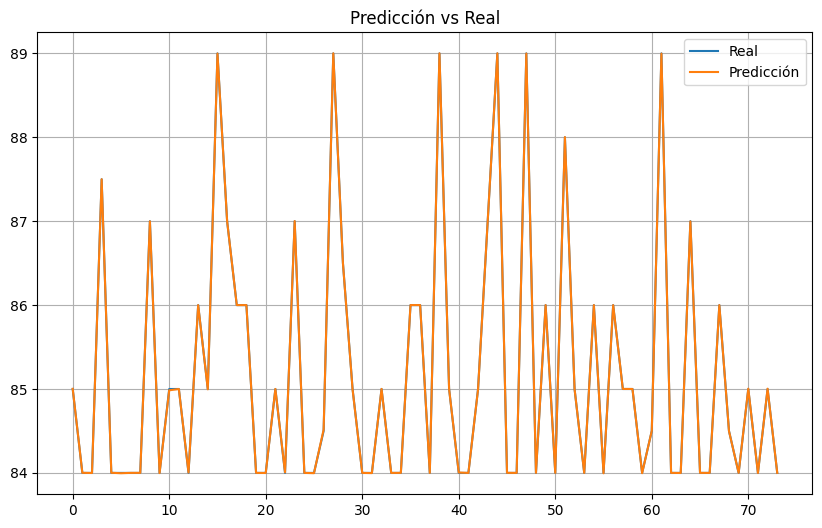

In [178]:
print("Rendimiento en entrenamiento")
y_train_pred, tmp = model_prediction(model, X_train, y_train)
plot_model(y_train, y_train_pred, tmp)

Rendimiento en prueba
Mean Squared Error: 0.047803737226786325
R^2 Score: 0.9609951976731241
Mean Absolute Error: 0.06966972351074219
Mean Absolute Percentage Error: 0.0814580937190449

Bias: 0.01900959014892578
Varianza: 1.1178356409072876


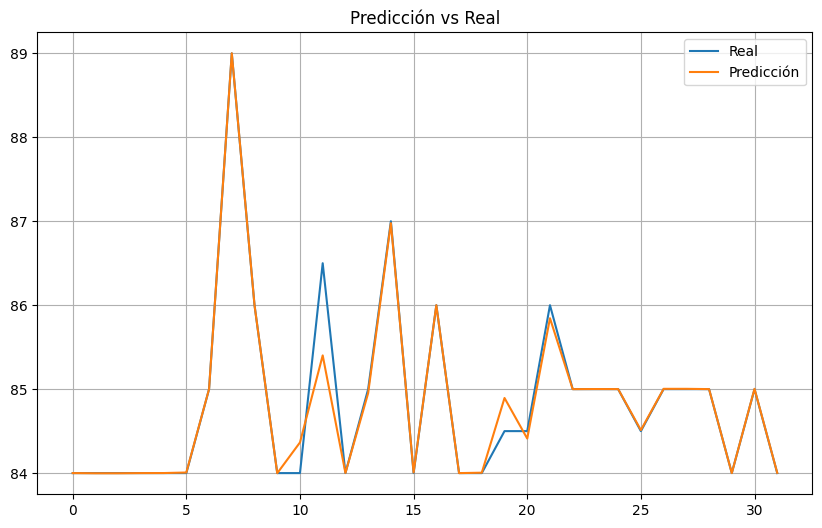

In [179]:
print("Rendimiento en prueba")
y_pred, tmp = model_prediction(model, X_test, y_test)
plot_model(y_test, y_pred, tmp)